# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.8.0
/device:GPU:0


In [2]:
# datasets for tf
from data_preprocessing_3d import get_dataset_large

batch_size = 4
dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\train"
)
dataset = dataset.shuffle(8).batch(batch_size)
valid_dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\valid"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

for sample in valid_dataset.take(10):
    print(sample[0].shape)
    print(sample[1].shape)
    print(np.min(sample[0]))
    print(np.max(sample[0]))

print(dataset)
print(valid_dataset)

['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images0.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images1.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images10.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images100.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images101.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images102.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images11.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images12.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images13.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images14.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images15.tfrecords', 'C:\\Use

In [3]:
### learning rate schedule

def scheduler(epoch, lr):
    if epoch < 2:
        lr = 0.001
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [4]:
# Network set-up
from utils import models

model = models.model_call(model_name="3DUNET",pxz=32,px=64,features=32)

In [5]:
# Metrics and training
 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision_all = tf.keras.metrics.Precision(
    thresholds=0.5)
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision_all,precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 32, 64, 64, 1)]         0           []                    
                                                                                                  
 conv3d (Conv3D)                (None, 32, 64, 64, 32)          896         ['input_1[0][0]']     
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64, 32)         128         ['conv3d[0][0]']      
 alization)                                                                                       
                                                                                                  
 conv3d_1 (Conv3D)              (None, 32, 64, 64, 64)          18496       ['batch_normalizat

In [202]:
# Results
# reading checkpoint if needen
#
#################################
import pandas as pd
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    ModelCheckpoint(
        "models\\3DUNET_lesion_32_32_64\\epoch-{epoch:02d}-valloss-{val_loss:.4f}-{val_precision_1:.2f}-{val_recall:.2f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
    ),
    TerminateOnNaN(),
]
epochs = 30

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0
)


hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/30


KeyboardInterrupt: 

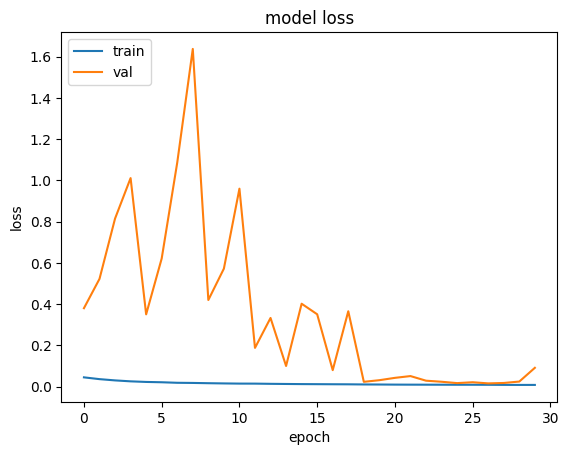

INFO:tensorflow:Assets written to: ram://ad702f97-a4e1-4759-9d76-acc0a704cf80/assets


In [ ]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

np.save("3Dunet_history_lesion.npy",np.array(history))



In [ ]:
#a zrób testowy trening od modelu do wątroby :))) mnoże będzie lepiej!

In [49]:
#model.load_weights(r"models\\3DUNET_lesion_32_32_64\\epoch-23-valloss-0.0288-0.72-0.74.hdf5")
model.load_weights(r"models\\3DUNET_lesion_32_32_64\\epoch-27-valloss-0.0158-0.69-0.77.hdf5")


#model.evaluate(valid_dataset)

In [52]:
k = 0
for volume,gt in valid_dataset.take(10):
    print(volume.shape)
    #print(k,np.where(gt[:,:,:,:,1]>0))
    preds = model.predict(volume)
    for j in range(4):
        if np.any(gt[j,:,:,:,1]>0):
            for i in range(32):
                plt.figure()
                plt.subplot(1,3,1)
                plt.imshow(volume[j,i,:,:,0])
                plt.subplot(1,3,2)
                plt.imshow(gt[j,i,:,:,1],vmin = 0,vmax =1)
                plt.subplot(1,3,3)
                plt.imshow(preds[j,i,:,:,1],vmin=0.5,vmax=0.51)
                plt.show()

# looks very promissing, but we need to transform the results to the full image as we typically use

(4, 32, 64, 64, 1)
(4, 32, 64, 64, 1)


KeyboardInterrupt: 

In [53]:
# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm
# load .nii file

#def few funtion to make predictions, WIP, they will be later added to Nii class

def preprocessing_3d(t1) -> np.ndarray:
    min = -200
    max = 200
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / max


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1

def label_seperator_liver(img):
        img = np.where(img == 2, 1, img)
        return img

path = "data\\LITS_Challenge\\Training_Batch_1"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")

print(files_volume[0])
print(files_segmenation[0])

data\LITS_Challenge\Training_Batch_1\volume-0.nii
data\LITS_Challenge\Training_Batch_1\segmentation-0.nii


In [77]:
volume_1 = reading_data(files_volume[4])
volume_1 = preprocessing_3d(volume_1)
print(np.min(volume_1))
print(np.max(volume_1))




seg_1 = reading_data(files_segmenation[4])
liver_1 = label_seperator_liver(seg_1)
seg_1 = label_seperator_lesion(seg_1)
seg_1 = tf.keras.utils.to_categorical(
                seg_1, 2
            )
print(volume_1.shape)
print(liver_1.shape)
print(seg_1.shape)

print(np.where(seg_1[:,:,:,1]>0)[0])
print(np.min(np.where(seg_1[:,:,:,1]>0)[0]))
print(np.max(np.where(seg_1[:,:,:,1]>0)[0]))

volume_1 = np.where(liver_1>0,volume_1,0)
"""for i in range(np.min(np.where(seg_1[:,:,:,1]>0)[0]),np.max(np.where(seg_1[:,:,:,1]>0)[0])):
    plt.subplot(1,2,1)
    plt.imshow(volume_1[i,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(seg_1[i,:,:,1])
    plt.show()"""


0.0
2.0
(455, 512, 512, 1)
(455, 512, 512, 1)
(455, 512, 512, 2)
[412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412
 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412
 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412
 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 412 413
 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413
 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413
 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413
 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413
 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413 413
 413 413 413 413 413 413 413 413 413 414 414 414 414 414 414 414 414 414
 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414
 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414 414
 414 414 414 414 414 414 414 414 414 414 414 414 414 414 41

'for i in range(np.min(np.where(seg_1[:,:,:,1]>0)[0]),np.max(np.where(seg_1[:,:,:,1]>0)[0])):\n    plt.subplot(1,2,1)\n    plt.imshow(volume_1[i,:,:,0])\n    plt.subplot(1,2,2)\n    plt.imshow(seg_1[i,:,:,1])\n    plt.show()'

In [78]:
# 1) going from top to the bottom, all slices even without the liver
# data preparation -> spreading data to quboids
n = (volume_1.shape[0] // 32) * 2 - 1
m = (volume_1.shape[1] // 64) * 2 - 1

chunk_size = 32
cords_shift = chunk_size // 2

print(chunk_size)
print(cords_shift)

total_q = n * m * m # total quboids

all_quboids = np.zeros((int(total_q//4 + 1), 4, chunk_size, chunk_size*2, chunk_size*2, 1))
all_quboids_seg = np.zeros((int(total_q//4 + 1), 4, chunk_size, chunk_size*2, chunk_size*2, 2))
preds = np.zeros((int(total_q//4 + 1), 4, chunk_size, chunk_size*2, chunk_size*2, 2))
print(all_quboids.shape)
batch_no = 0
q = 0
for z in tqdm(range(n)):  # z direction
    for y in range((m)):
        for x in range((m)):
            tmp_image = volume_1[
                z * cords_shift : z * cords_shift + chunk_size,
                y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                0:1,
            ]

            tmp_seg = seg_1[
                            z * cords_shift : z * cords_shift + chunk_size,
                            y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                            x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                            0:2,
                        ]
            
            all_quboids[batch_no,q,:,:,:,0:1] = tmp_image
            all_quboids_seg[batch_no,q,:,:,:,0:2] = tmp_seg
            q += 1
            if q > 3:
                batch_no += 1
                q = 0
            
            """
            tmp_seg = seg_1[
                z * cords_shift : z * cords_shift + chunk_size,
                y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                0:2,
            ]"""



# prediction for whole 


for i in tqdm(range(len(all_quboids))):
    preds[i] = model.predict(all_quboids[i])

print(preds.shape)
print("done")

32
16
(1519, 4, 32, 64, 64, 1)


100%|██████████| 1519/1519 [03:44<00:00,  6.78it/s]

(1519, 4, 32, 64, 64, 2)
done


In [79]:
# rebuild the standart view by averanging

a = 0
final_preds = np.zeros((np.shape(seg_1)))
print(final_preds.shape)
"""for batch in tqdm(preds):
    for i,example in enumerate(batch):
        
            print("z",z * cords_shift , z * cords_shift + chunk_size)
        break
    break
print(a)
print(final_preds.shape)
"""
i = 0
j = 0
for z in tqdm(range(n)):  # z direction
    for y in range((m)):
        for x in range((m)):
            final_preds[
                z * cords_shift : z * cords_shift + chunk_size,
                y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                0:2,
            ] += preds[i,j,:,:,:,0:2]
            j+=1
            if j>3:
                i+=1
                j=0


            a+=1


final_preds = final_preds/8

print(a)
print(i)
print(j)

(455, 512, 512, 2)


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


6075
1518
3


In [68]:
"""
for i in tqdm(range(len(all_quboids))):
    for j in range(4):
        for z in range(0,32,3):
            if np.any(all_quboids_seg[i,j,z,:,:,1]>0):
                plt.subplot(1,3,1)
                plt.imshow(all_quboids[i,j,z,:,:,0])
                plt.subplot(1,3,2)
                plt.imshow(preds[i,j,z,:,:,1])
                plt.subplot(1,3,3)
                plt.imshow(all_quboids_seg[i,j,z,:,:,1])
                plt.show()"""

'\nfor i in tqdm(range(len(all_quboids))):\n    for j in range(4):\n        for z in range(0,32,3):\n            if np.any(all_quboids_seg[i,j,z,:,:,1]>0):\n                plt.subplot(1,3,1)\n                plt.imshow(all_quboids[i,j,z,:,:,0])\n                plt.subplot(1,3,2)\n                plt.imshow(preds[i,j,z,:,:,1])\n                plt.subplot(1,3,3)\n                plt.imshow(all_quboids_seg[i,j,z,:,:,1])\n                plt.show()'

In [81]:
lesion = final_preds[:,:,:,1]
print(np.max(lesion))
threshold = 0.01
#lesion = np.where(lesion>threshold,1,0)
print(np.max(final_preds[:,:,:,1]))


0.8654100596904755
0.8654100596904755


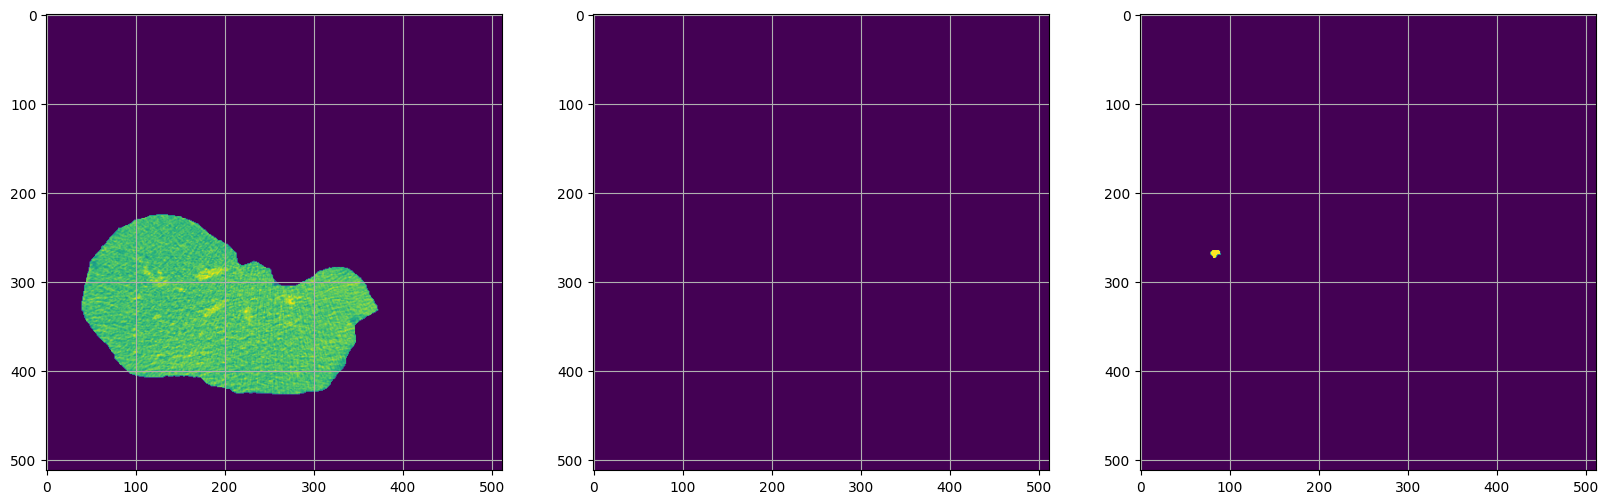

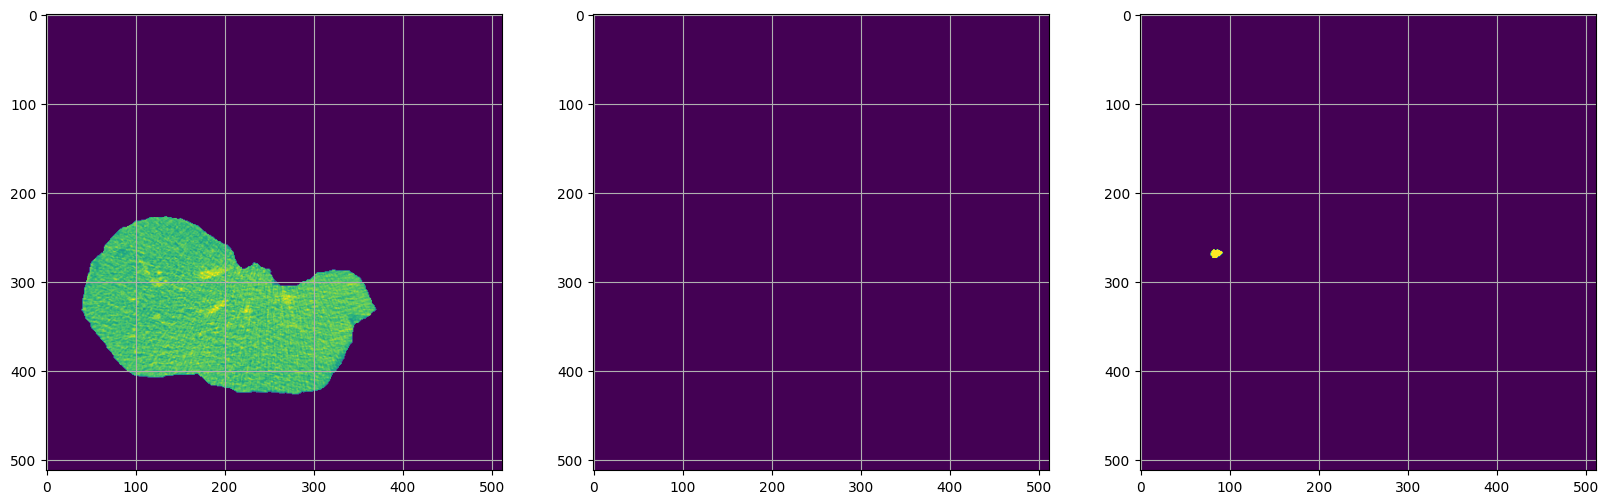

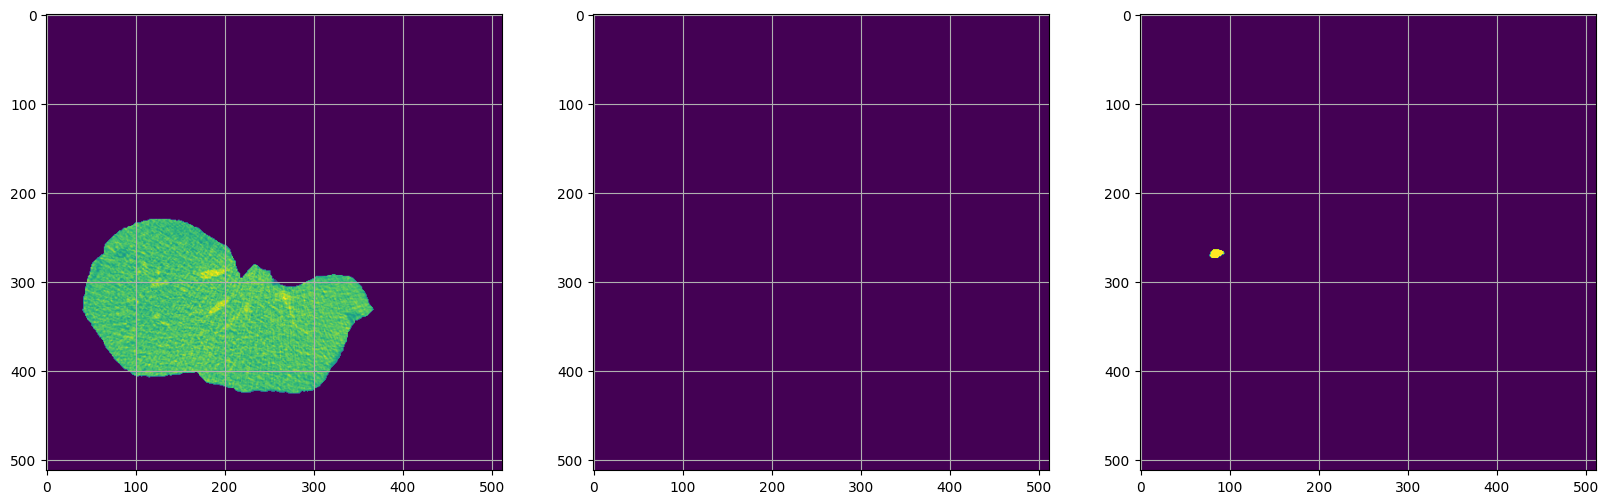

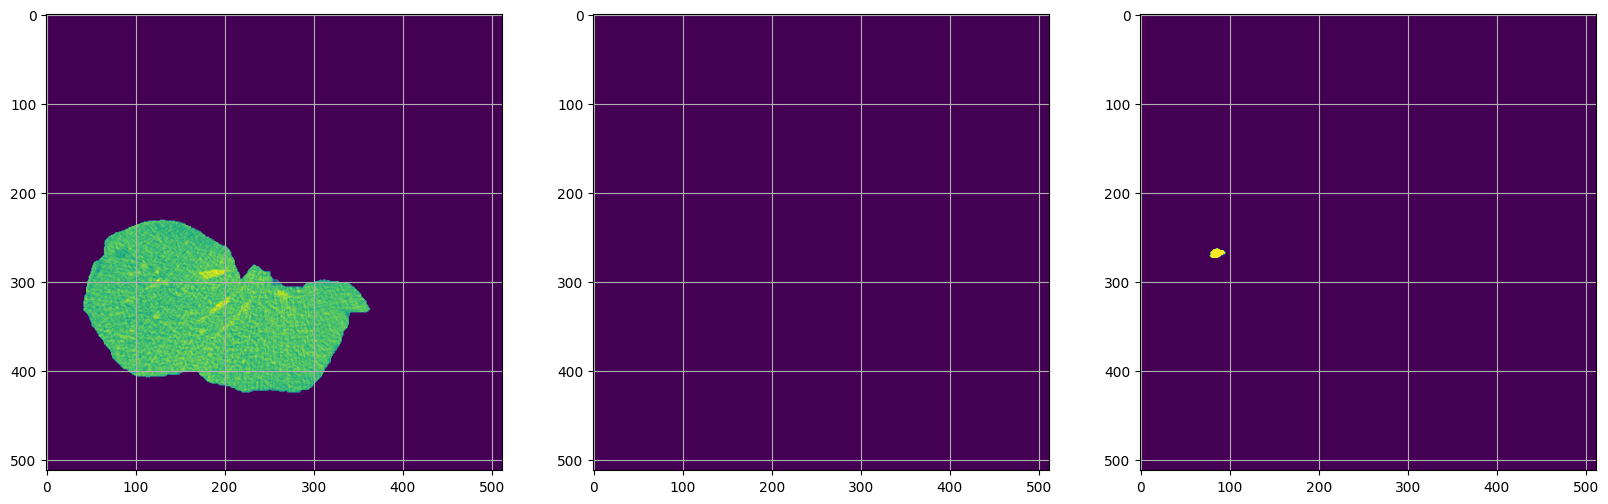

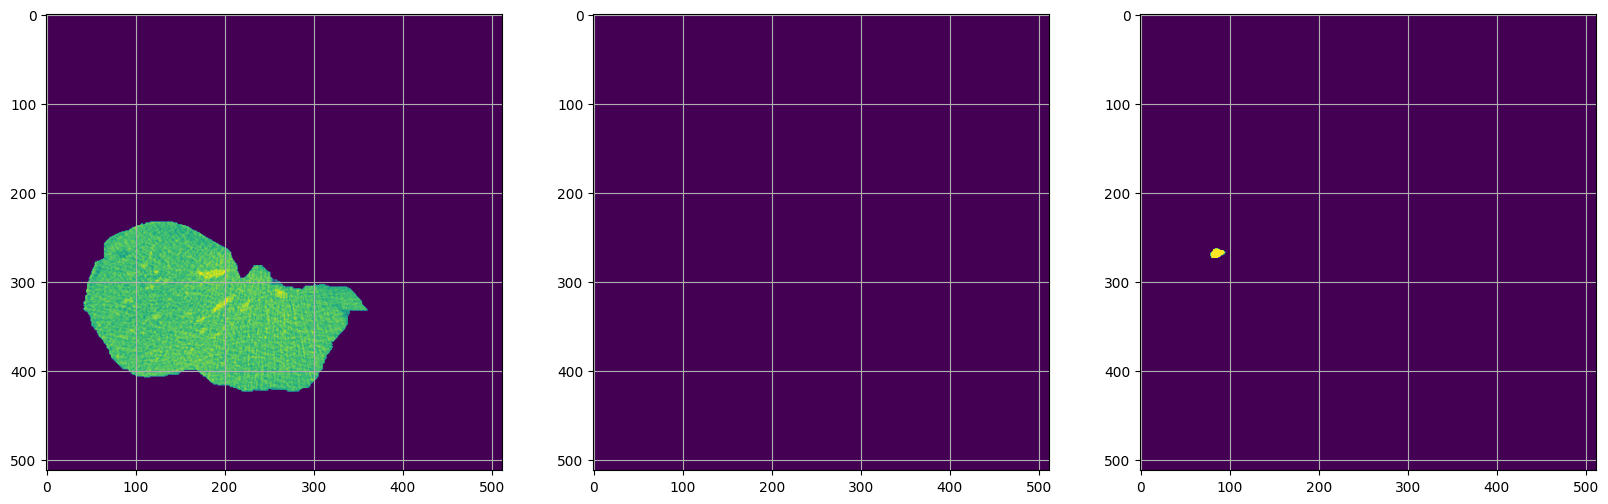

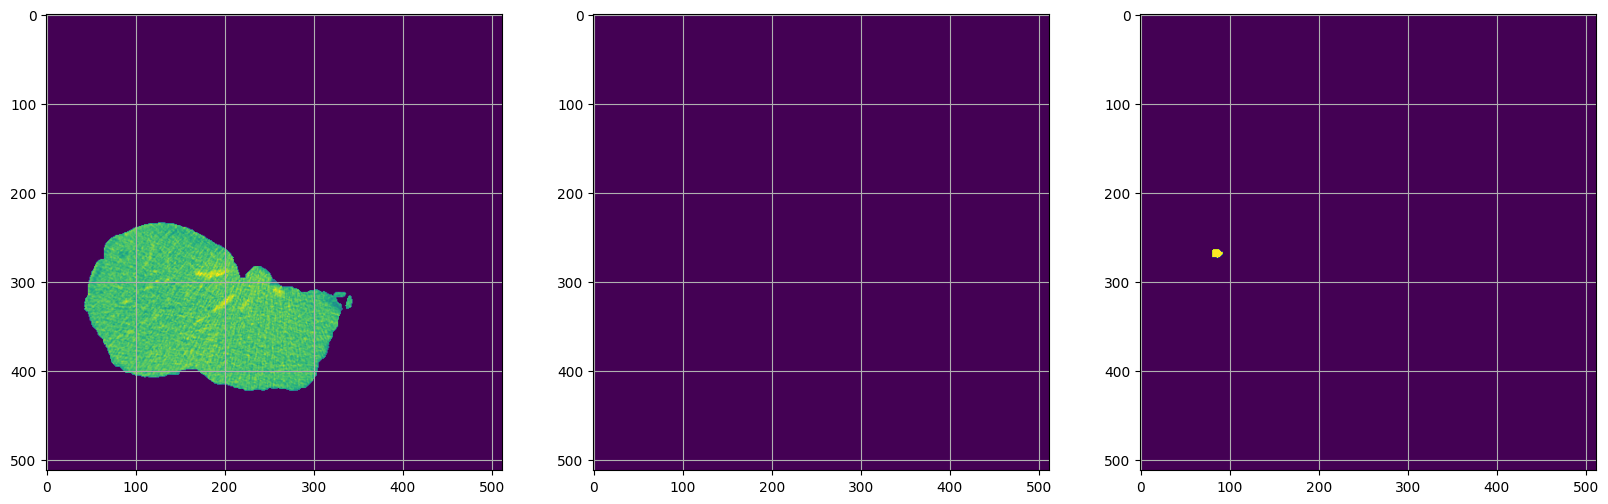

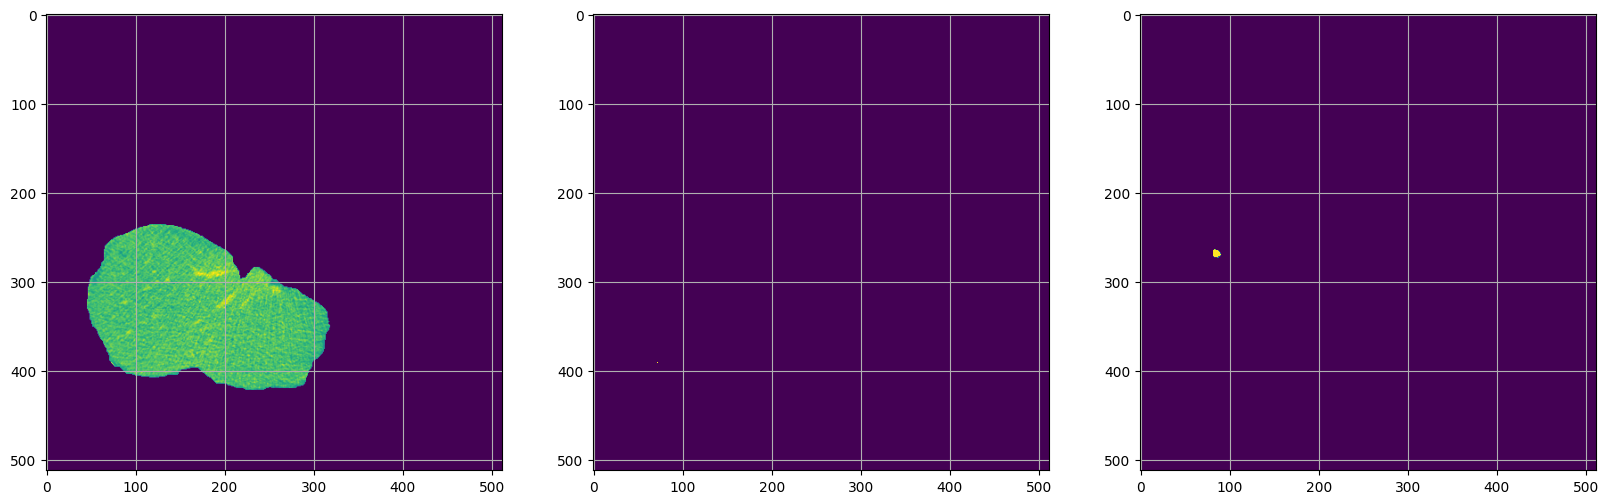

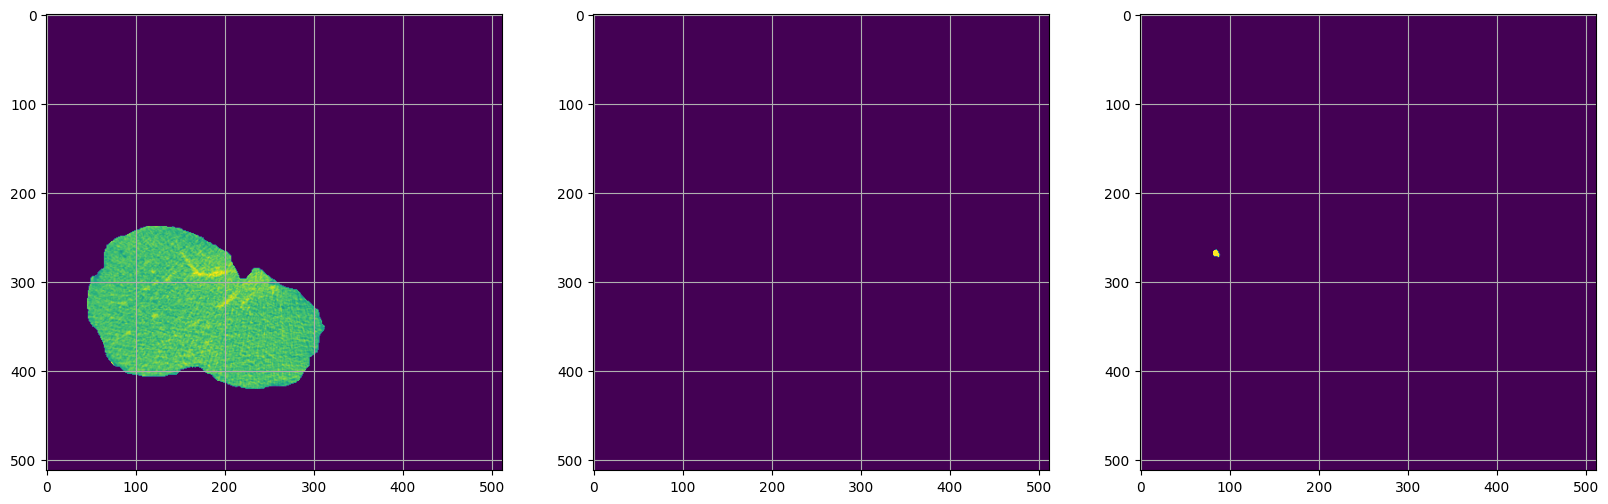

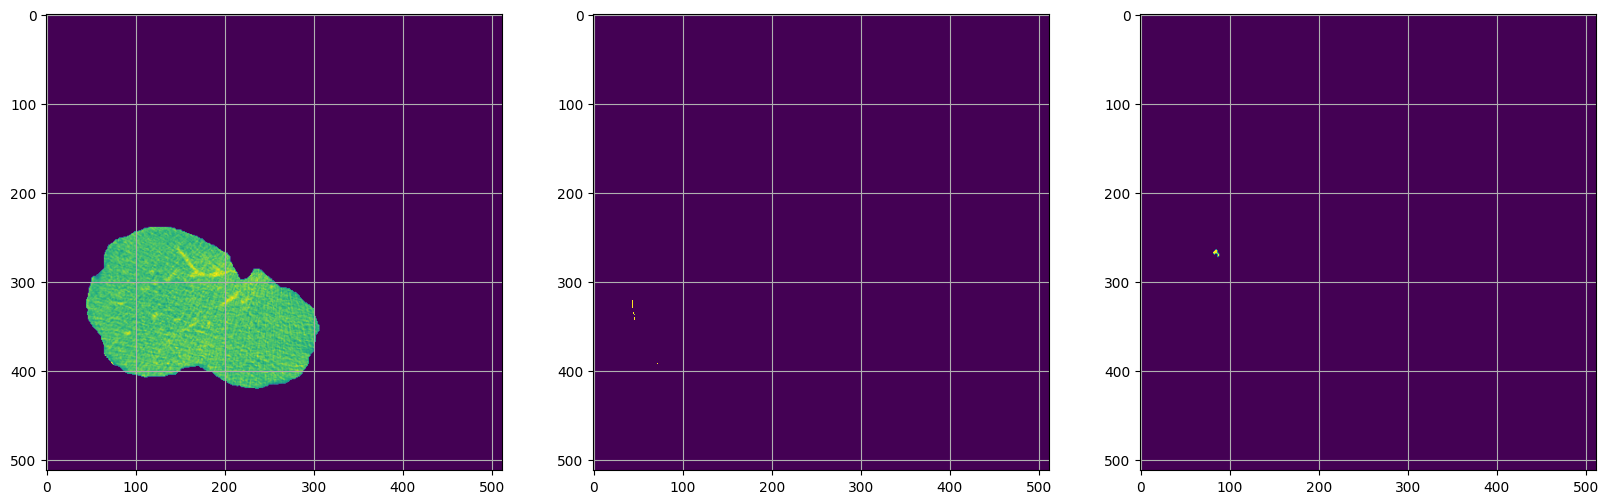

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [82]:
FP = tf.keras.metrics.FalsePositives(thresholds=0.5)

TP = tf.keras.metrics.TruePositives(thresholds=0.5)

FN = tf.keras.metrics.FalseNegatives(thresholds=0.5)
TP.update_state(seg_1[:, :, :, 1], final_preds[:, :, :, 1])
FP.update_state(seg_1[:, :, :, 1], final_preds[:, :, :, 1])
FN.update_state(seg_1[:, :, :, 1], final_preds[:, :, :, 1])

prec = TP.result() / (TP.result() + FP.result())
recall = TP.result() / (TP.result() + FN.result())

plt.rcParams["figure.figsize"] = (20, 15)
for i in range(np.shape(volume_1)[0]):
    if np.any(volume_1[i, :, :, 0]) > 0 and np.any(seg_1[i, :, :, 1]) > 0.1:
        plt.subplot(1, 3, 1)
        plt.imshow(volume_1[i, :, :, 0])
        plt.grid()
        plt.subplot(1, 3, 2)
        plt.imshow(lesion[i, :, :], vmin=0.5, vmax=0.51)
        plt.grid()
        plt.subplot(1, 3, 3)
        plt.imshow(seg_1[i, :, :, 1])
        plt.grid()
        plt.show()
        plt.close()


print(prec)
print(recall)

In [ ]:
# 2) only part with the liver

[[0.99998903 1.         1.         ... 1.         1.         0.99999988]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.99999988 1.         1.         ... 1.         1.         1.        ]
 [0.99999821 1.         1.         ... 1.         1.         0.99999988]]


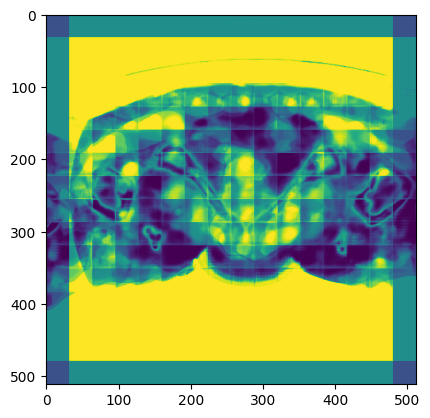

In [ ]:
print(final_preds[3,:,:,0])
plt.imshow((final_preds[3,:,:,0]))

Wnioski:


- działa, cały pipeline działa
- sieć wymaga modyfikacji do tego podejścia

- wykrywa poprawie większe zmiany, nie wykrywa małych, jest to związane z architekturą sieci
-- do tego problemu trzeba to zrobić inaczej, więcej kanałów na normalnym poziomie, mniej na niższym, ew zrobić nawet jednopoziomowy encoder dekoder (i więcej cech)
- podejście nie wydaje się złe, tylko wymaga faktycznie dostosowania pod siebie kilku aspektów, szczególnie do szuaknia małych zmian